In [1]:
!nvidia-smi

Sun Oct 23 18:33:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 30%   39C    P8    34W / 350W |   3329MiB / 24259MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset,DataLoader
from datetime import datetime
from tqdm import tqdm
import sys
import torch.optim as optim
import argparse
import  os, glob
import  random, csv
from    PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from utils import train2
from utils import plot_history
torch.__version__

/media/tjubme/BFFF9639F5C15953/QiuZhaoyu/envs/zhaoyu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.7.1'

In [3]:
class PCGload(Dataset):
    def __init__(self, root, resize, label):
        super(PCGload, self).__init__()

        self.root = root
        self.resize = resize
        self.name2label = label # "n":0  "abn":1
        self.images, self.labels = self.load_csv('images.csv')

    def load_csv(self, filename):

        if not os.path.exists(os.path.join(self.root, filename)):
            images = []
            for name in self.name2label.keys():
                # 'pokemon\\mewtwo\\00001.png
                images += glob.glob(os.path.join(self.root, name, '*.png'))
                # images += glob.glob(os.path.join(self.root, name, '*.jpg'))
                # images += glob.glob(os.path.join(self.root, name, '*.jpeg'))

            # 1167, 'pokemon\\bulbasaur\\00000000.png'
            print(len(images), images)

            random.shuffle(images)
            with open(os.path.join(self.root, filename), mode='w', newline='') as f:
                writer = csv.writer(f)
                for img in images: # 'pokemon\\bulbasaur\\00000000.png'
                    name = img.split(os.sep)[-2]
                    label = self.name2label[name]
                    # 'pokemon\\bulbasaur\\00000000.png', 0
                    writer.writerow([img, label])
                print('writen into csv file:', filename)

        # read from csv file
        images, labels = [], []
        with open(os.path.join(self.root, filename)) as f:
            reader = csv.reader(f)
            for row in reader:
                # 'pokemon\\bulbasaur\\00000000.png', 0
                img, label = row
                label = int(label)

                images.append(img)
                labels.append(label)

        assert len(images) == len(labels)

        return images, labels



    def __len__(self):

        return len(self.images)

    def __getitem__(self, idx):
        # idx~[0~len(images)]
        # self.images, self.labels
        # img: 'pokemon\\bulbasaur\\00000000.png'
        # label: 0
        img, label = self.images[idx], self.labels[idx]

        tf = transforms.Compose([
            lambda x:Image.open(x).convert('RGB'), # string path= > image data
            transforms.Resize((int(self.resize*1.25), int(self.resize*1.25))),
            transforms.RandomRotation(15),
            transforms.CenterCrop(self.resize),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        img = tf(img)
        label = torch.tensor(label)


        return  img,label

In [4]:
label = {'n': 0, 'abn': 1}
Batch_Size = 256
train_db = PCGload('/media/tjubme/BFFF9639F5C15953/QiuZhaoyu/PCG/main-1channel/dataset_mfcc/train_1/train', 32, label)
test_db = PCGload('/media/tjubme/BFFF9639F5C15953/QiuZhaoyu/PCG/main-1channel/dataset_mfcc/train_1//test', 32, label)
trainloader = DataLoader(train_db, batch_size=Batch_Size, shuffle=True,num_workers=0)
testloader = DataLoader(test_db, batch_size=Batch_Size, num_workers=0)

# ResNet

In [5]:
class BasicBlock(nn.Module):
    """
    对于浅层网络，如ResNet-18/34等，用基本的Block
    基础模块没有压缩,所以expansion=1
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
            nn.Conv2d(out_channels,out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        # 如果输入输出维度不等，则使用1x1卷积层来改变维度
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
    def forward(self, x):
        out = self.features(x)
#         print(out.shape)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out
class Bottleneck(nn.Module):
    """
    对于深层网络，我们使用BottleNeck，论文中提出其拥有近似的计算复杂度，但能节省很多资源
    zip_channels: 压缩后的维数，最后输出的维数是 expansion * zip_channels
    针对ResNet50/101/152的网络结构,主要是因为第三层是第二层的4倍的关系所以expansion=4
    """
    expansion = 4
    
    def __init__(self, in_channels, zip_channels, stride=1):
        super(Bottleneck, self).__init__()
        out_channels = self.expansion * zip_channels
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, zip_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.features(x)
#         print(out.shape)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out
class ResNet(nn.Module):
    """
    不同的ResNet架构都是统一的一层特征提取、四层残差，不同点在于每层残差的深度。
    对于cifar10，feature map size的变化如下：
    (32, 32, 3) -> [Conv2d] -> (32, 32, 64) -> [Res1] -> (32, 32, 64) -> [Res2] 
 -> (16, 16, 128) -> [Res3] -> (8, 8, 256) ->[Res4] -> (4, 4, 512) -> [AvgPool] 
 -> (1, 1, 512) -> [Reshape] -> (512) -> [Linear] -> (10)
    """
    def __init__(self, block, num_blocks, num_classes=2, verbose = False):
        super(ResNet, self).__init__()
        self.verbose = verbose
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        #使用_make_layer函数生成上表对应的conv2_x, conv3_x, conv4_x, conv5_x的结构
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # cifar10经过上述结构后，到这里的feature map size是 4 x 4 x 512 x expansion
        # 所以这里用了 4 x 4 的平均池化
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 第一个block要进行降采样
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            # 如果是Bottleneck Block的话需要对每层输入的维度进行压缩，压缩后再增加维数
            # 所以每层的输入维数也要跟着变
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.features(x)
        if self.verbose:
            print('block 1 output: {}'.format(out.shape))
        out = self.layer1(out)        
        if self.verbose:
            print('block 2 output: {}'.format(out.shape))
        out = self.layer2(out)
        if self.verbose:
            print('block 3 output: {}'.format(out.shape))
        out = self.layer3(out)
        if self.verbose:
            print('block 4 output: {}'.format(out.shape))
        out = self.layer4(out)
        if self.verbose:
            print('block 5 output: {}'.format(out.shape))
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [6]:
def ResNet18(verbose=False):
    return ResNet(BasicBlock, [2,2,2,2],verbose=verbose)
device = 'cuda' if torch.cuda.is_available() else 'cpu' # 判断是否用GPU
net = ResNet18(True).to(device)

In [7]:
summary(net,(3,32,32))

block 1 output: torch.Size([2, 64, 32, 32])
block 2 output: torch.Size([2, 64, 32, 32])
block 3 output: torch.Size([2, 128, 16, 16])
block 4 output: torch.Size([2, 256, 8, 8])
block 5 output: torch.Size([2, 512, 4, 4])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchN

In [8]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,verbose=True,patience = 5,min_lr = 0.000001) # 动态更新学习率
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

In [9]:
net = torch.load('./ResNet_50.pth')  # 加载模型
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
torch.cuda.empty_cache()
net.eval()  # 把模型转为test模式

DataParallel(
  (module): ResNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (features): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (features): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, ep

In [10]:
with torch.no_grad():
    for data in testloader:  # 循环每一个batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)  # 输入网络进行测试

        # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)          # 更新测试图片的数量
        correct += (predicted == labels).sum() # 更新正确分类的图片的数量

    print('Accuracy of the network on the test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the test images: 88.79 %


In [11]:
classes = ('normal',  'HF')
# 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
    #4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
print('TP: %.2f'%class_correct[0])
print('FN: %.2f'%(class_total[0]-class_correct[0]))
print('TN: %.2f'%class_correct[1])
print('FP: %.2f'%(class_total[1]-class_correct[1]))
print('Acc: %.2f%%'%(100*(class_correct[0]+class_correct[1])/(class_total[0]+class_total[1])))
print('Se: %.2f%%'%(100*(class_correct[0])/(class_total[0])))
print('Sp: %.2f%%'%(100*(class_correct[1])/(class_total[1])))
print('MAcc: %.2f%%'%(((100*(class_correct[0])/(class_total[0]))+(100*(class_correct[1])/(class_total[1])))/2))

TP: 55.00
FN: 8.00
TN: 38.00
FP: 6.00
Acc: 86.92%
Se: 87.30%
Sp: 86.36%
MAcc: 86.83%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy Rate = 91.58878504672897%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 1800x288 with 0 Axes>

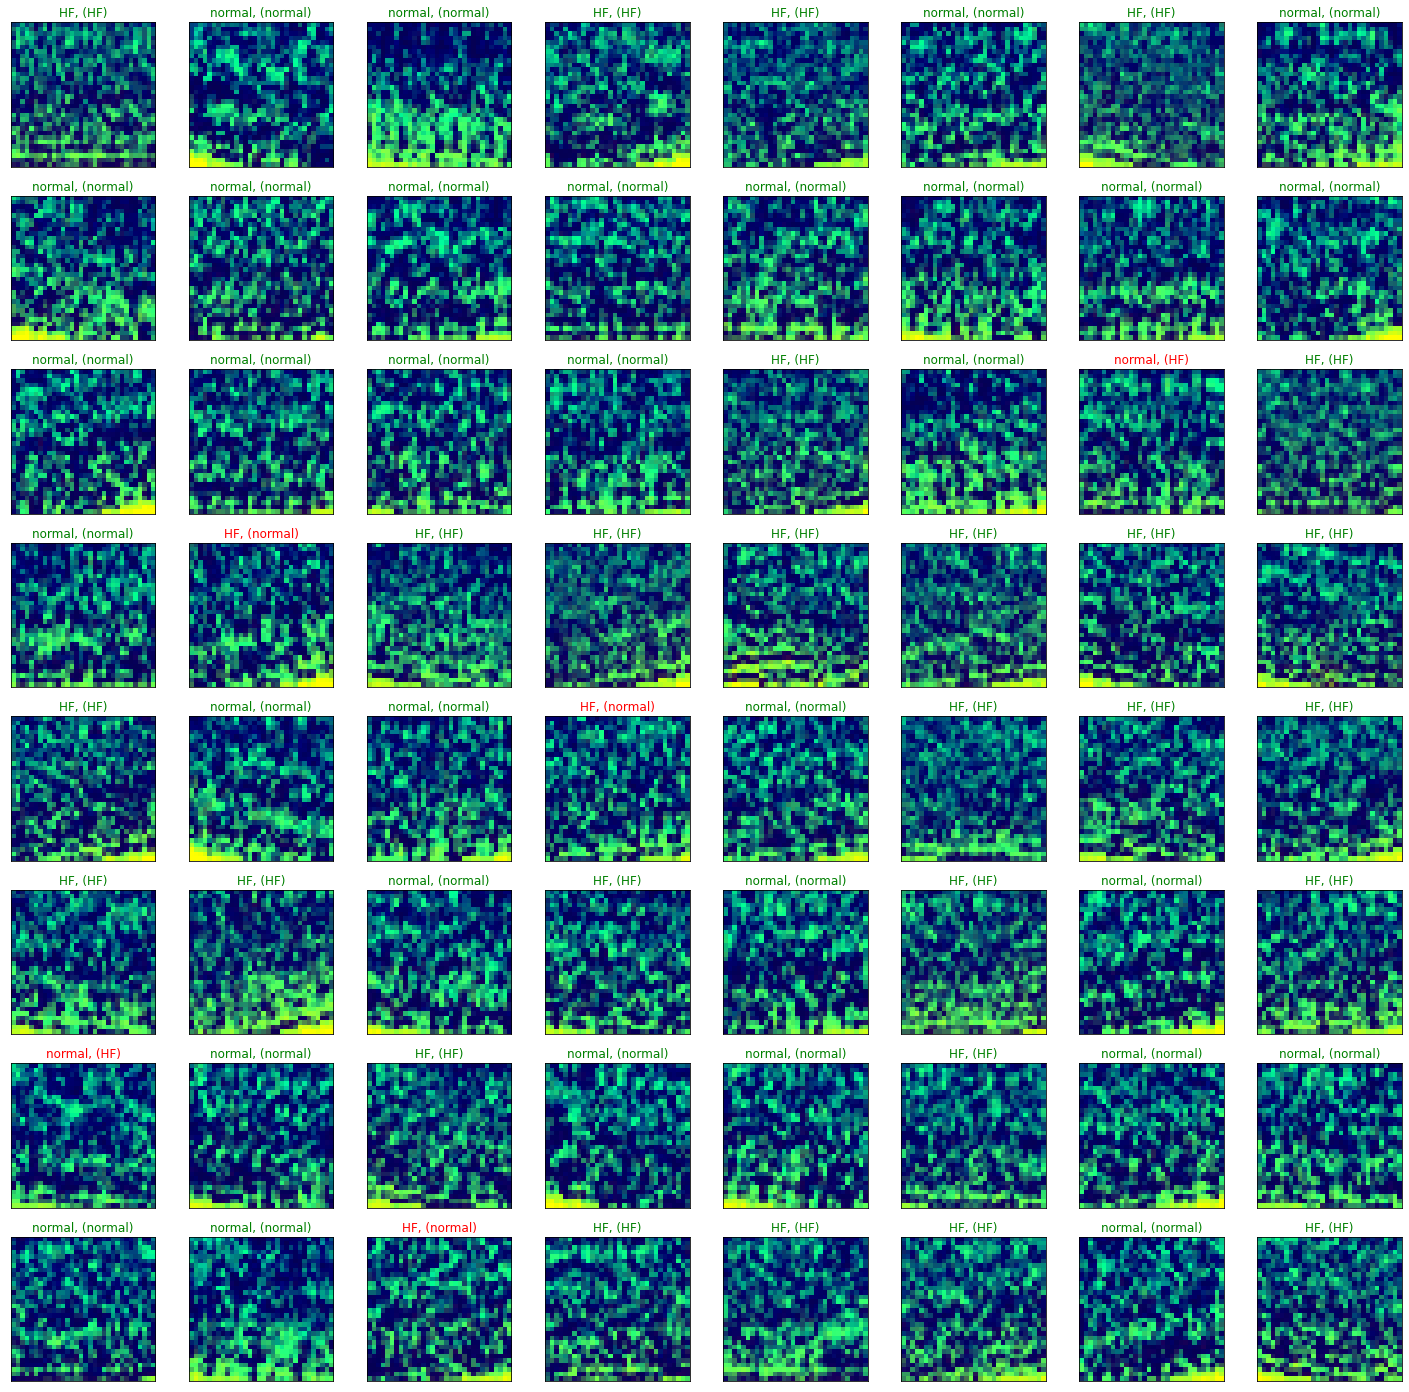

In [12]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()


print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

# MobileNetV1

In [13]:
class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self,in_channels,out_channels,stride=1):
        super(Block,self).__init__()
        # groups参数就是深度可分离卷积的关键
        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size=3,stride=stride,
                               padding=1,groups=in_channels,bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,padding=0,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
    def forward(self,x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        return x
        
# 深度可分离卷积 DepthWise Separable Convolution
class MobileNetV1(nn.Module):
    # (128,2) means conv channel=128, conv stride=2, by default conv stride=1
    cfg = [64,(128,2),128,(256,2),256,(512,2),512,512,512,512,512,(1024,2),1024]
    
    def __init__(self, num_classes=10,alpha=1.0,beta=1.0):
        super(MobileNetV1,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=1,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.avg = nn.AvgPool2d(kernel_size=2)
        self.layers = self._make_layers(in_channels=32)
        self.linear = nn.Linear(1024,num_classes)
    
    def _make_layers(self, in_channels):
        layers = []
        for x in self.cfg:
            out_channels = x if isinstance(x,int) else x[0]
            stride = 1 if isinstance(x,int) else x[1]
            layers.append(Block(in_channels,out_channels,stride))
            in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.layers(x)
        x = self.avg(x)
        x = x.view(x.size()[0],-1)
        x = self.linear(x)
        return x
net = MobileNetV1(num_classes=2).to(device)
net = torch.load('./MobileNetV1_50.pth')  # 加载模型
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
torch.cuda.empty_cache()
net.eval()  # 把模型转为test模式

DataParallel(
  (module): MobileNetV1(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (avg): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layers): Sequential(
      (0): Block(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (conv2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU()
      )
      (1): Block(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [14]:
classes = ('normal',  'HF')
# 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
    #4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
print('TP: %.2f'%class_correct[0])
print('FN: %.2f'%(class_total[0]-class_correct[0]))
print('TN: %.2f'%class_correct[1])
print('FP: %.2f'%(class_total[1]-class_correct[1]))
print('Acc: %.2f%%'%(100*(class_correct[0]+class_correct[1])/(class_total[0]+class_total[1])))
print('Se: %.2f%%'%(100*(class_correct[0])/(class_total[0])))
print('Sp: %.2f%%'%(100*(class_correct[1])/(class_total[1])))
print('MAcc: %.2f%%'%(((100*(class_correct[0])/(class_total[0]))+(100*(class_correct[1])/(class_total[1])))/2))

TP: 58.00
FN: 5.00
TN: 39.00
FP: 5.00
Acc: 90.65%
Se: 92.06%
Sp: 88.64%
MAcc: 90.35%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy Rate = 92.5233644859813%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 1800x288 with 0 Axes>

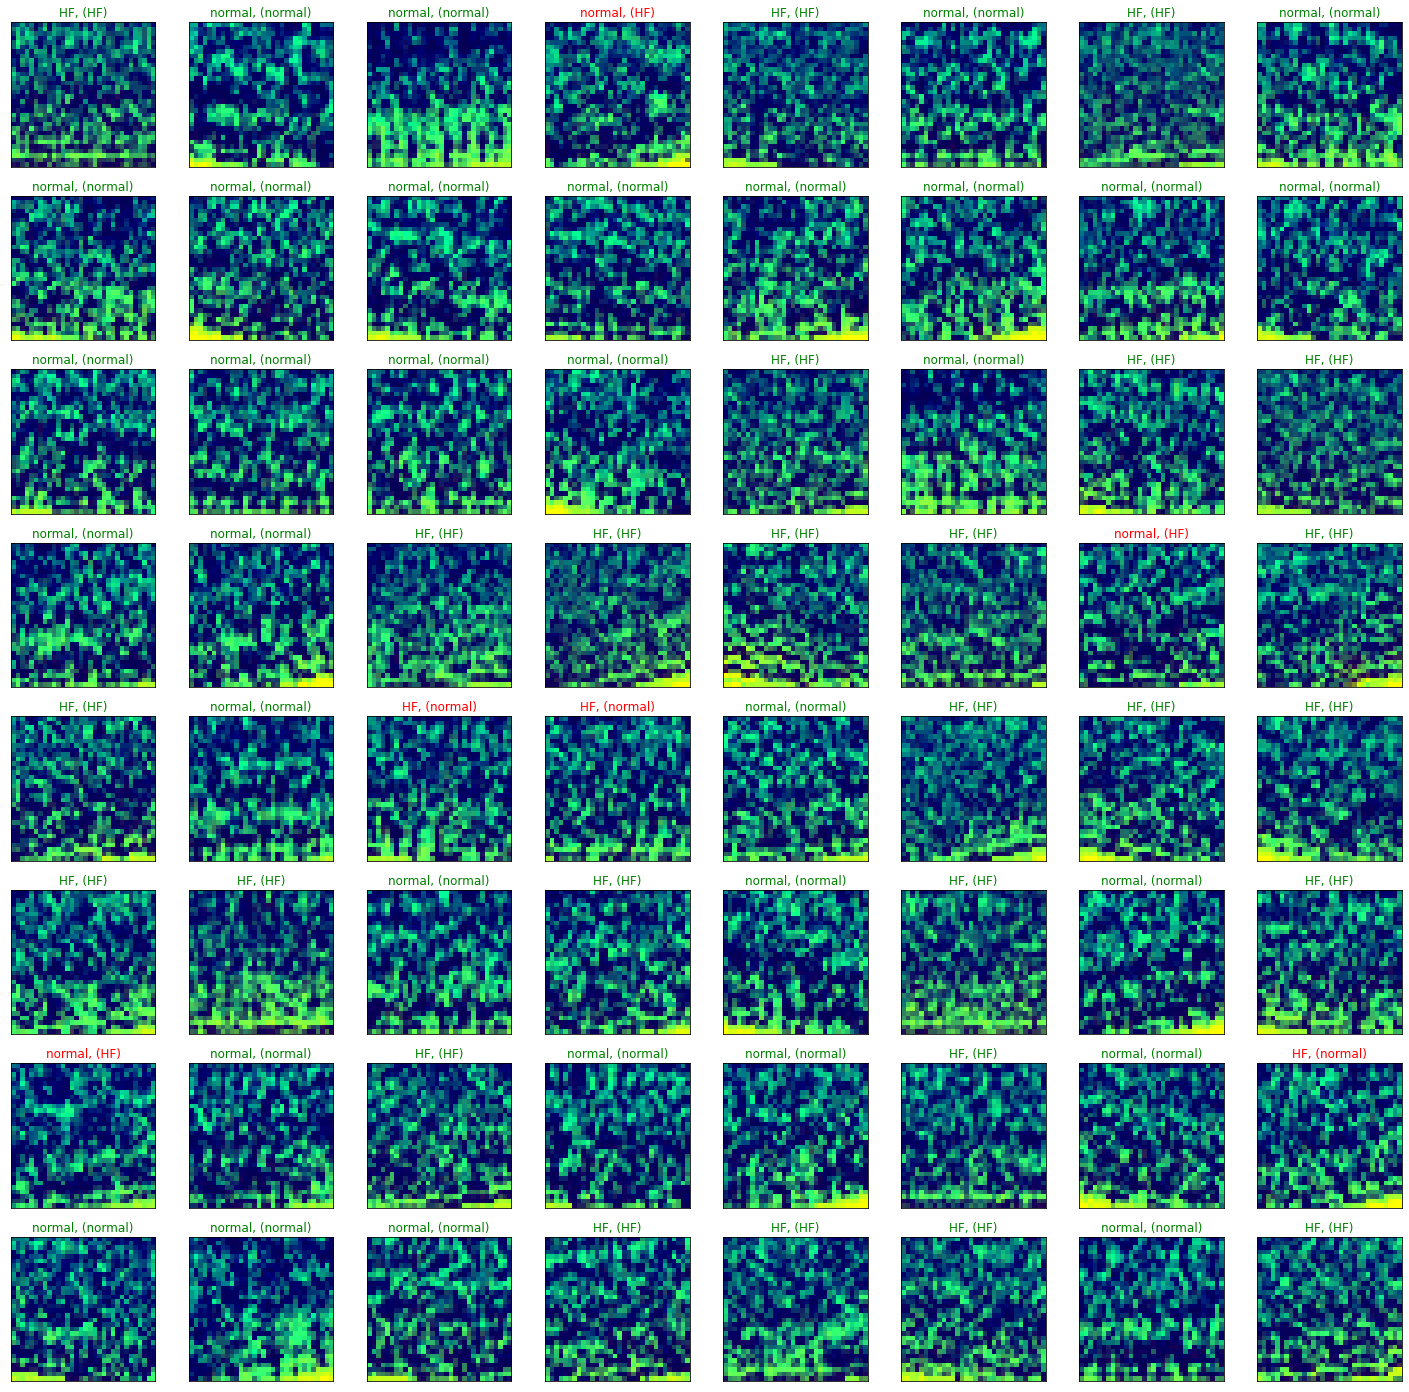

In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()


print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

# DenseNet

In [16]:
class Bottleneck(nn.Module):
    """
    Dense Block
    这里的growth_rate=out_channels, 就是每个Block自己输出的通道数。
    先通过1x1卷积层，将通道数缩小为4 * growth_rate，然后再通过3x3卷积层降低到growth_rate。
    """
    # 通常1×1卷积的通道数为GrowthRate的4倍
    expansion = 4
    
    def __init__(self, in_channels, growth_rate):
        super(Bottleneck, self).__init__()
        zip_channels = self.expansion * growth_rate
        self.features = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(True),
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(True),
            nn.Conv2d(zip_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        )
        
    def forward(self, x):
        out = self.features(x)
        out = torch.cat([out, x], 1)
        return out        
class Transition(nn.Module):
    """
    改变维数的Transition层 具体包括BN、ReLU、1×1卷积（Conv）、2×2平均池化操作
    先通过1x1的卷积层减少channels，再通过2x2的平均池化层缩小feature-map
    """
    # 1×1卷积的作用是降维，起到压缩模型的作用，而平均池化则是降低特征图的尺寸。
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.features = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(2)
        )
        
    def forward(self, x):
        out = self.features(x)
        return out
# DesneNet-BC
# B 代表 bottleneck layer(BN-RELU-CONV(1x1)-BN-RELU-CONV(3x3))
# C 代表压缩系数(0<=theta<=1)
import math
class DenseNet(nn.Module):
    """
    Dense Net
    paper中growth_rate取12，维度压缩的参数θ，即reduction取0.5
    且初始化方法为kaiming_normal()
    num_blocks为每段网络中的DenseBlock数量
    DenseNet和ResNet一样也是六段式网络（一段卷积+四段Dense+平均池化层），最后FC层。
    第一段将维数从3变到2 * growth_rate
    
    (3, 32, 32) -> [Conv2d] -> (24, 32, 32) -> [layer1] -> (48, 16, 16) -> [layer2]
  ->(96, 8, 8) -> [layer3] -> (192, 4, 4) -> [layer4] -> (384, 4, 4) -> [AvgPool]
  ->(384, 1, 1) -> [Linear] -> (10)
    
    """
    def __init__(self, num_blocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.reduction = reduction
        
        num_channels = 2 * growth_rate
        
        self.features = nn.Conv2d(3, num_channels, kernel_size=3, padding=1, bias=False)
        self.layer1, num_channels = self._make_dense_layer(num_channels, num_blocks[0])
        self.layer2, num_channels = self._make_dense_layer(num_channels, num_blocks[1])
        self.layer3, num_channels = self._make_dense_layer(num_channels, num_blocks[2])
        self.layer4, num_channels = self._make_dense_layer(num_channels, num_blocks[3], transition=False)
        self.avg_pool = nn.Sequential(
            nn.BatchNorm2d(num_channels),
            nn.ReLU(True),
            nn.AvgPool2d(4),
        )
        self.classifier = nn.Linear(num_channels, num_classes)
        
        self._initialize_weight()
        
    def _make_dense_layer(self, in_channels, nblock, transition=True):
        layers = []
        for i in range(nblock):
            layers += [Bottleneck(in_channels, self.growth_rate)]
            in_channels += self.growth_rate
        out_channels = in_channels
        if transition:
            out_channels = int(math.floor(in_channels * self.reduction))
            layers += [Transition(in_channels, out_channels)]
        return nn.Sequential(*layers), out_channels
    
    def _initialize_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
    
    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
def DenseNet121():
    return DenseNet([6,12,24,16], growth_rate=32)

def DenseNet169():
    return DenseNet([6,12,32,32], growth_rate=32)

def DenseNet201():
    return DenseNet([6,12,48,32], growth_rate=32)

def DenseNet161():
    return DenseNet([6,12,36,24], growth_rate=48)

def densenet_cifar():
    return DenseNet([6,12,24,16], growth_rate=12)
device = torch.device("cuda")
net = densenet_cifar().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True 
net = torch.load('./Denset_50.pth')  # 加载模型
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
torch.cuda.empty_cache()
net.eval()  # 把模型转为test模式

DenseNet(
  (features): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (features): Sequential(
        (0): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (1): Bottleneck(
      (features): Sequential(
        (0): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv2

In [17]:
classes = ('normal',  'HF')
# 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
    #4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
print('TP: %.2f'%class_correct[0])
print('FN: %.2f'%(class_total[0]-class_correct[0]))
print('TN: %.2f'%class_correct[1])
print('FP: %.2f'%(class_total[1]-class_correct[1]))
print('Acc: %.2f%%'%(100*(class_correct[0]+class_correct[1])/(class_total[0]+class_total[1])))
print('Se: %.2f%%'%(100*(class_correct[0])/(class_total[0])))
print('Sp: %.2f%%'%(100*(class_correct[1])/(class_total[1])))
print('MAcc: %.2f%%'%(((100*(class_correct[0])/(class_total[0]))+(100*(class_correct[1])/(class_total[1])))/2))

TP: 62.00
FN: 1.00
TN: 42.00
FP: 2.00
Acc: 97.20%
Se: 98.41%
Sp: 95.45%
MAcc: 96.93%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy Rate = 98.13084112149532%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 1800x288 with 0 Axes>

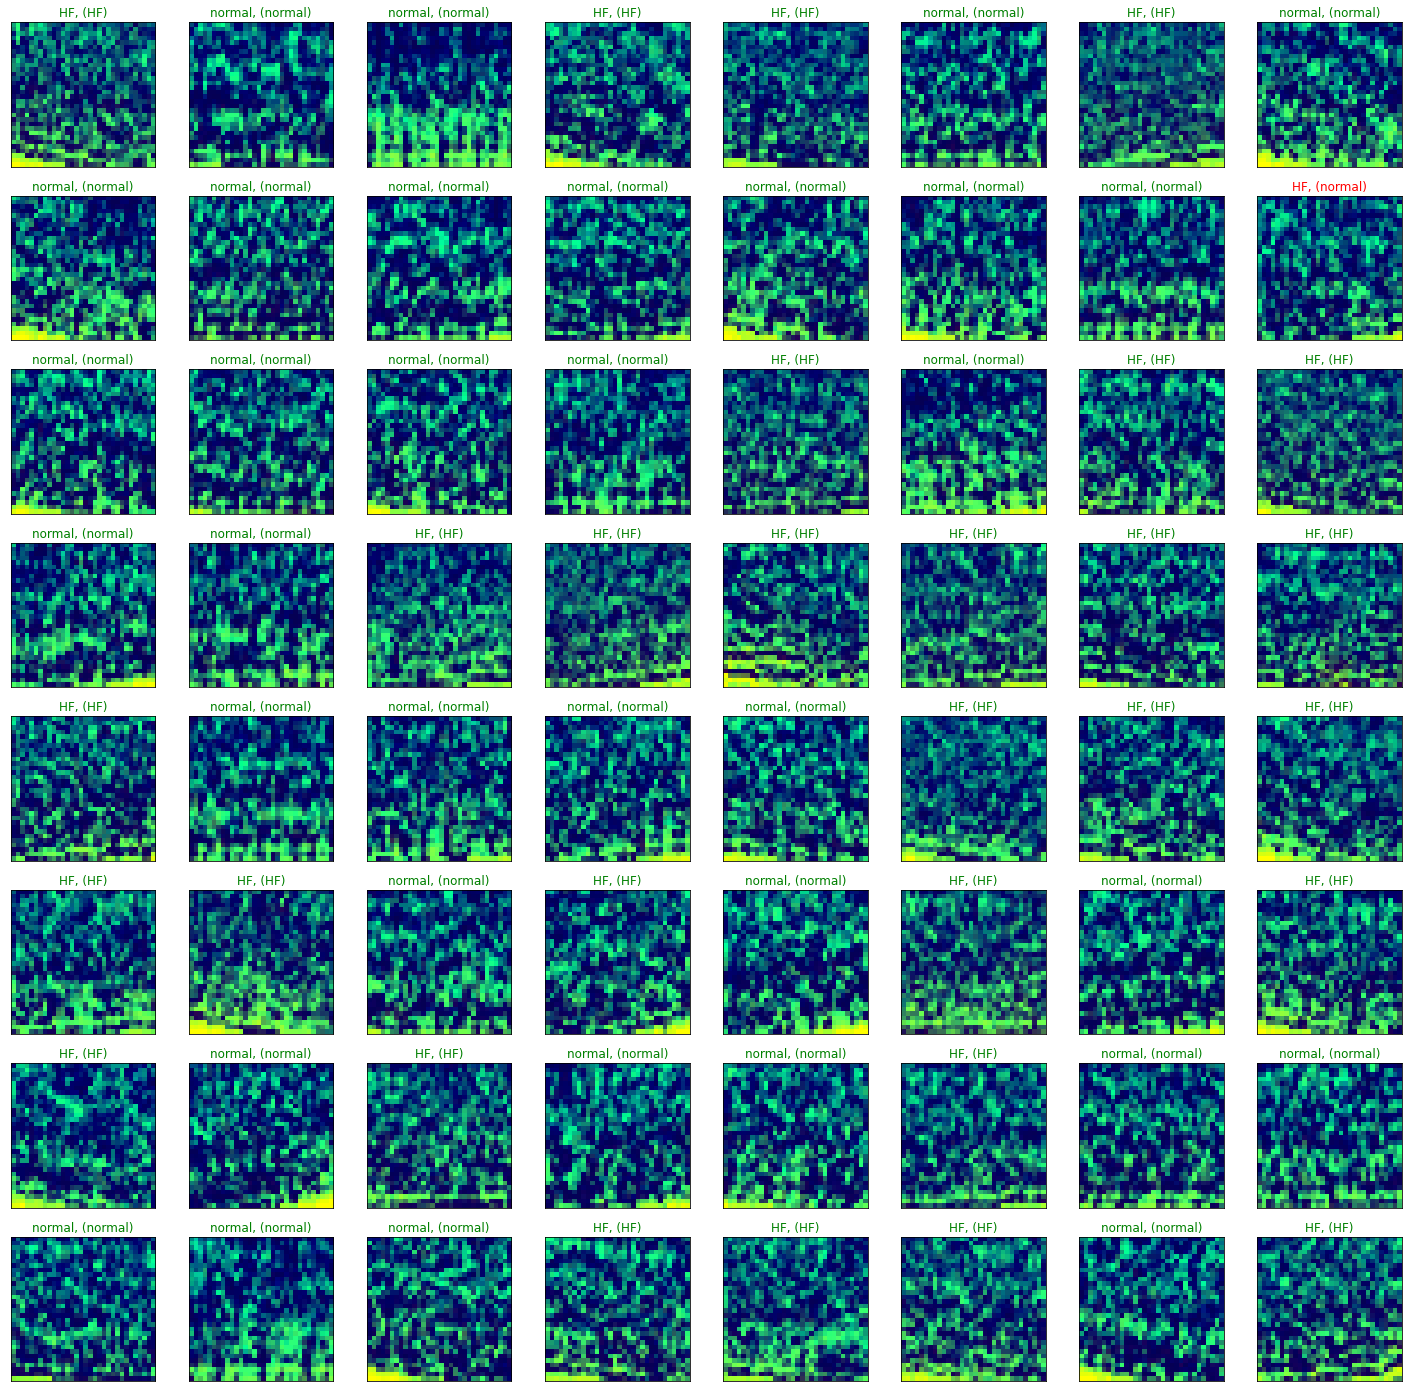

In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()


print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))